# Applying AutoAttack
This notebook provides a beginner friendly introduction to using auto attack on image classification as part of Test & Evaluation of a small benchmark dataset xView. Auto attack is an ensemble or a collection of other attacks or attack configuration, which can be run in parallel. In this notebook, we learn how to instantiate the attack and deduce which attack from all is the most successful. Testing an ensemble of attacks for best performance is a crucial step in T&E.

__Intended Audience__: All T&E users

__Requirements__: Basic Python and Torchvision / ML skills.

__Time Required__: Full run of the notebook: <2 minutes

## Contents
1. Imports
2. Load xView data and model for classification
3. Auto attack initialization
4. Auto attack evaluation
5. Calculate Clean and Robust accuracy
6. Further evaluation: Visualize samples and crafted examples, best attacks
7. Conclusion 
8. Next steps

## Take-away
- Autoattack bundles several attacks or parameters for a different attack
- This allows easy evalution, as the best attack (configuration) can be found

## 1. Imports

We import all necessary libraries for this tutorial. In this order, we first import general libraries such as numpy, then load relevant methods from ART. We then load the corresponding HEART functionality and specific torch functions to support the model. Lastly, we use a command to plot within the notebook.

In [2]:
import numpy as np
import os
import torch
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
import torchvision

# ART imports
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch import ProjectedGradientDescentPyTorch
from art.attacks.evasion.auto_attack import AutoAttack

# HEART imports
from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from heart_library.attacks.attack import JaticAttack
from heart_library.metrics import AccuracyPerturbationMetric

# MAITE import for evaluation
from maite.protocols.image_classification import Dataset as ic_dataset

# using matplotlib inline to see the figures
%matplotlib inline

## 2. Load xView data and model for classification
We now load the data, importing only a small part to save compute for this small demonstration. We then define the model and wrap it as JATIC pytorch classifier.

Here, we first define the xView labels and then load xView images as ```numpy arrays```. We use a subset of the data to save runtime, a total of 15 samples. In addition, we load a dataset as a modified dataframe to be compatible with JATIC.

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

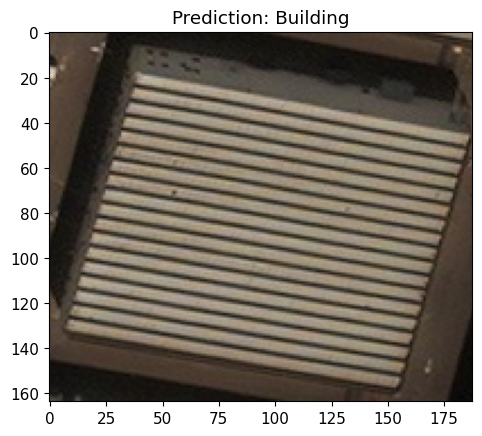

In [3]:
labels = {
    0:'Building',
    1:'Construction Site',
    2:'Engineering Vehicle',
    3:'Fishing Vessel',
    4:'Oil Tanker',
    5:'Vehicle Lot'
}

data = load_dataset("CDAO/xview-subset-classification", split="test[0:15]")
idx = 3
plt.title(f"Prediction: {labels[data[idx]['label']]}")
plt.imshow(data[idx]['image'])

'''
Transform dataset
'''
IMAGE_H, IMAGE_W = 224, 224

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])
data = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))

sample_data = torch.utils.data.Subset(data, range(5))

We load a simple classification model from the repo and wrap it in ```JaticPyTorchClassifier``` so the model is compatible with  __maite__ .

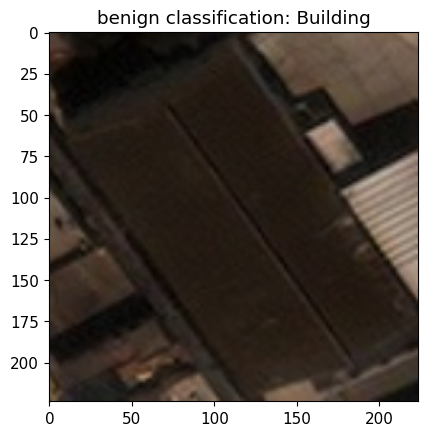

In [4]:
model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(labels.keys())) 
model.load_state_dict(torch.load('../../../utils/resources/models/xview_model.pt'))
#_ = model.eval()

'''
Wrap the model
'''
jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(labels), clip_values=(0, 1)
)

#plot original image
pred_batch = jptc(sample_data)
plt.imshow(to_image(data[1]['image']))
_ = plt.title(f'benign classification: {labels[np.argmax(np.stack(pred_batch[1]))]}')
plt.show()

## 3. Autoattack initialization
We now initialize autoattack. To this end, we create a number of differently initialized attacks to carry out the T&E. For example, we
- vary the max_iter values, but keep all other parameters fixed,
- and vary the eps_step values, but keep all other parameters fixed.
  
These values serve as a mere example, other parameters can/should be further explored, as well as applying different attacks. **Important to know:** If we use attacks that are untargeted and ask auto attack to executed targeted mode, the attacks will still be executed, *but in untargeted mode*.

In case there is no intuition about which parameters could be tested, we show below a default initialization for autoattack's parameters.

In [6]:
n = 5 # number of iterations
attacks = []

# create multiple values for max_iter
max_iter = [i+1 for i in list(range(n))]
print('max_iter values:', max_iter)

# create multiple values for eps
eps_steps = [round(float(i/100+0.001), 3) for i in list(range(n))]
print('eps_step values:', eps_steps)

# make a list with all attack/parameter combinations we want to test
for i, eps_step in enumerate(eps_steps):
    attacks.append(
        ProjectedGradientDescentPyTorch(
            estimator=jptc,
            norm=np.inf,
            eps=0.1,
            eps_step=eps_step,
            max_iter=10,
            targeted=False,
            batch_size=32,
            verbose=False
        )
    )
    attacks.append(
        ProjectedGradientDescentPyTorch(
            estimator=jptc,
            norm=np.inf,
            eps=0.1,
            max_iter=max_iter[i],
            targeted=False,
            batch_size=32,
            verbose=False
        )
    )
    
print('Number of attacks:', len(attacks))

parallel_pool_size =2

# add the attacks to Autoattack to manage execution, and wrap with JAticattack to support MAITE
jatic_attack_parallel = JaticAttack(AutoAttack(estimator=jptc, attacks=attacks, targeted=True), norm=2)
jatic_attack_notparallel = JaticAttack(AutoAttack(estimator=jptc, attacks=attacks, targeted=True), norm=2)

## In case you have no intuition about possible parameters, defaults can be used:
#attack = JaticAttack(AutoAttack(
#    estimator=ptc,
#    targeted=True,
#    parallel=True,
#))


max_iter values: [1, 2, 3, 4, 5]
eps_step values: [0.001, 0.011, 0.021, 0.031, 0.041]
Number of attacks: 10


## 4. Auto Attack evaluation

We are now executing the attacks using HEART in non-parallel mode and HEART in parallel mode. For each of two cases, we compute whether the attack is robust: if it is, predictions for each image will be incorrect.

When rerunning this notebook with your own parameters, all the attacks (or your attack) should be fully robust.

In [7]:
# Run HEART attack in non-parallel mode
nonparallel_adv, y_nonparallel, metadata_nonparallel = jatic_attack_notparallel(data=sample_data)
predictions_jatic_notparallel = np.sum(np.argmax(np.stack(jptc(nonparallel_adv)), axis=1) == data['label'][0:5]) == 0
print(f'Is HEART non-parallel attack fully robust: {predictions_jatic_notparallel}')

# Run HEART attack in parallel mode
parallel_adv, y_parallel, metadata_parallel = jatic_attack_parallel(data=sample_data,parallel_pool_size=parallel_pool_size)
predictions_jatic_parallel = np.sum(np.argmax(np.stack(jptc(parallel_adv)), axis=1) == data['label'][0:5]) == 0
print(f'Is HEART parallel attack fully robust: {predictions_jatic_parallel}')

Is HEART non-parallel attack fully robust: True
Is HEART parallel attack fully robust: True


## 5. Calculate clean and robust accuracy

In addition to the above robustness, we compute the three different numbers: the clean accuracy, the robust accuracy, and the perturbation size. We define:
- **clean accuracy**: the accuracy of the classification model on the original, benign, images
- **robust accuracy**: the accuracy of the classification  model on the adversarial images
- **perturbation size**: this is the average perturbation added to all images which successfully fooled the classification model

In [8]:
benign_pred_batch = jptc(sample_data)
groundtruth_target_batch = sample_data[:5]["label"]
adv_pred_batch = jptc(parallel_adv)

metric = AccuracyPerturbationMetric(np.stack(benign_pred_batch), metadata_parallel)
metric.update(np.stack(adv_pred_batch), groundtruth_target_batch)
print(metric.compute())

{'clean_accuracy': 1.0, 'robust_accuracy': 0.0, 'mean_delta': 22.376106}


## 6. Further evaluation: Visualize samples and crafted examples, best attacks

We plot the data in four collumns, including the original sample, and the three examples generated by auto attack in the order: ART core Autoattack, ART JATIC autoattack non-paralell, and and ART JATIC in parallel mode. 

- The first collum with the original image shows the ground truth label and the classifier prediction on the original image. Note that as we are passing ground truth labels to the __generate__ method, attacks will not add perturbations to images that are already misclassified. Perturbations are only added to images in which the classifier made correct predictions.

- The second column images are adversarial images generated by ART core AutoAttack. L2 distance between the original and adversarial image is shown. 

- The third column images are adversarial images generated by ART JATIC AutoAttack in non-parallel mode - these should be identical to ART core (a sanity check).

- The fourth column images are adversarial images generated by ART JATIC AutoAttack in parallel mode. Note how parallel model achieves lower L2 distance between the original and adversarial image - as all jobs are run in parallel mode, more attacks can be evaluated and successful attacks with lower perturbations added can be selected.

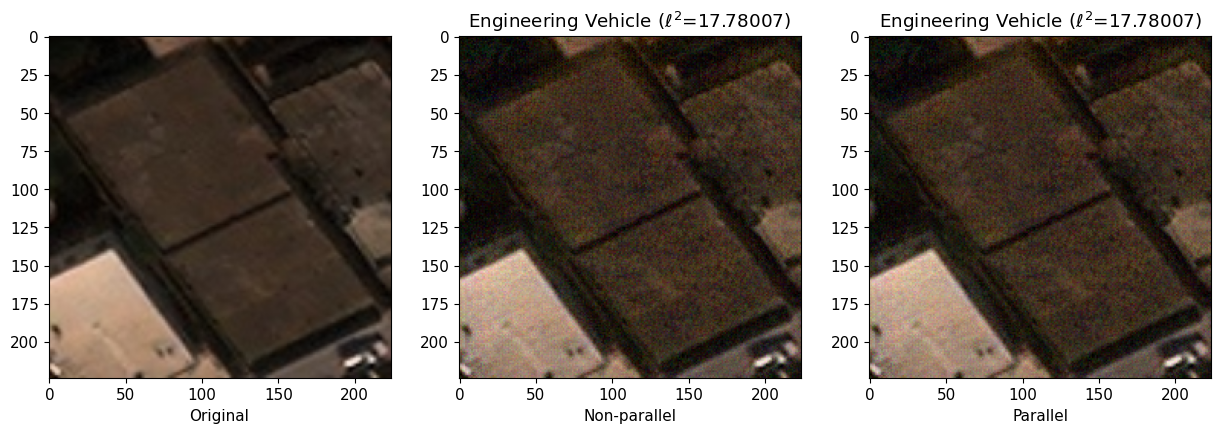

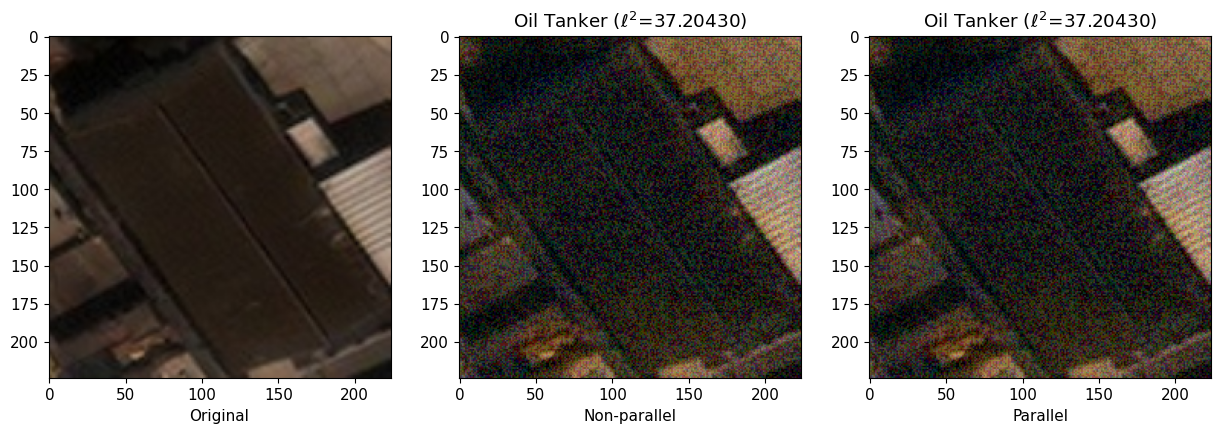

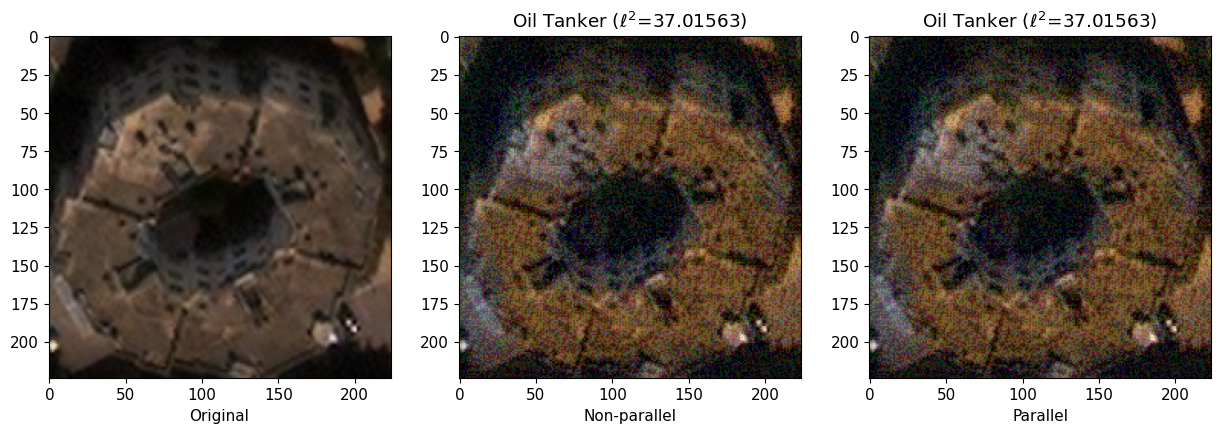

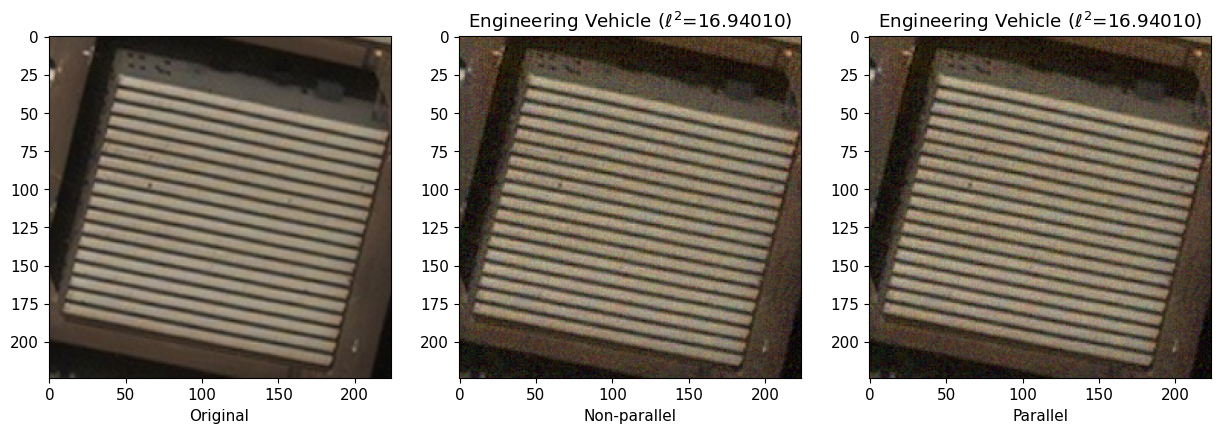

In [9]:
# to plot all images
#for i in range(len(x_train)):
for i in range(4):
    f, ax = plt.subplots(1,3, constrained_layout = False)

    #core_perturbation = np.linalg.norm(sample_data[i]['image'] - core_adv[[i]])
    nonparallel_perturbation = np.linalg.norm(sample_data[i]['image'] - nonparallel_adv[i])
    parallel_perturbation = np.linalg.norm(sample_data[i]['image'] - parallel_adv[i])
    
    pred_core_benign = jptc(sample_data)
    #pred_core_adv = ptc.predict(core_adv[i])
    pred_non_parallel_adv = np.stack(jptc(nonparallel_adv))
    pred_parallel_adv = np.stack(jptc(parallel_adv))

    #ax[0].set_title(f'GT: {labels[data[i]['label']]};  Pred: {labels[np.argmax(pred_core_benign[i])]}')
    ax[0].imshow(to_image(data[i]['image']))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'{labels[np.argmax(pred_non_parallel_adv[i])]} ($\\ell ^{2}$={nonparallel_perturbation:.5f})')
    ax[1].imshow(nonparallel_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Non-parallel')

    ax[2].set_title(f'{labels[np.argmax(pred_parallel_adv[i])]} ($\\ell ^{2}$={parallel_perturbation:.5f})')
    ax[2].imshow(parallel_adv[i].transpose(1,2,0))
    ax[2].set_xlabel('Parallel')
    f.set_figwidth(15)
    plt.show()

Autoattack has the additional feature, that it will, for any input sample, return the best performing attack and its configuration. We will plot this now for inspection.

In [10]:
print(jatic_attack_parallel._attack)

AutoAttack(targeted=True, parallel_pool_size=0, num_attacks=10)
BestAttacks:
image 1: ProjectedGradientDescentPyTorch(norm=inf, eps=0.1, eps_step=0.011, targeted=True, num_random_init=0, batch_size=32, minimal=False, summary_writer=None, decay=None, max_iter=10, random_eps=False, verbose=False, )
image 2: ProjectedGradientDescentPyTorch(norm=inf, eps=0.1, eps_step=0.1, targeted=True, num_random_init=0, batch_size=32, minimal=False, summary_writer=None, decay=None, max_iter=1, random_eps=False, verbose=False, )
image 3: ProjectedGradientDescentPyTorch(norm=inf, eps=0.1, eps_step=0.1, targeted=True, num_random_init=0, batch_size=32, minimal=False, summary_writer=None, decay=None, max_iter=1, random_eps=False, verbose=False, )
image 4: ProjectedGradientDescentPyTorch(norm=inf, eps=0.1, eps_step=0.011, targeted=True, num_random_init=0, batch_size=32, minimal=False, summary_writer=None, decay=None, max_iter=10, random_eps=False, verbose=False, )
image 5: ProjectedGradientDescentPyTorch(norm

## 7. Conclusion
We have learned that Autoattack applies a collection of attacks, how to initilaize this collection, and how to determine which performed best. Autoattack is an easy way to security test an existing model, as it runs different parameters and attacks without us explicitely running and comparing them.

## 8. Next steps
- [4. How to Create Defenses for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/4_How_to_Create_Defenses_for_Image_Classification.ipynb)
- [5. How to Replace Datasets in Model Evaluation](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/5_How_to_Replace_Datasets_in_Model_Evaluation.ipynb)